# [IAPR][iapr]: Lab 1 ‒  Image segmentation

**Group ID:** 22

**Author 1 (sciper):** Alexander Pisarewski (269689)  
**Author 2 (sciper):** Guillaume Champain (261737)   
**Author 3 (sciper):** Adrien AMOROS (322927)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

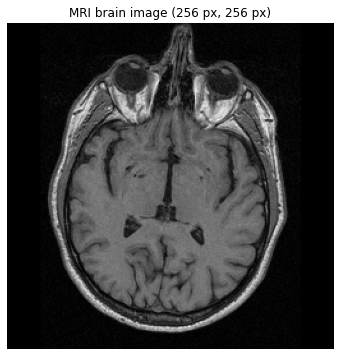

In [2]:
import skimage.io
import skimage.measure
import skimage.filters
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

#### Process explanation
In order to find an approximate greyscale value representing well the brain surface, a 20x20 pixels sample is taken and its mean is computed in order to get an idea of around which value we are interested.
Two thresholds are defined, below and above which the pixels are considered in or out of the brain zone.
A starting point inside the brain zone is then manually defined.
The main work consists in exploring the zone from the starting point : while the complete region of interest is not ran through, we keep exploring the surrounding pixels.

The 8 surrounding pixels are being traveled for each pixel of interest.
- When a pixel has never been seen : it is labeled as "part of the brain" if it lies inside the threshold range, and labeled as "no part of the brain" if not
- If a pixel has already been explored, it is re processed once to make sure no point was forgotten

When the algorithm does not find any more point of interest, it stops. Lastly a mask removing the values of no interest is applied so that the brain only is shown.

Advantages : 
- The region growing algorithm is useful to isolate elements of interest that are surrounded by other elements we do not focus the study on.
- Several criteria can be chosen to define the growing behavior
- Labeling of points allow a rapid computation for "reasonable" sized images

Limitations :
- It can be sensitive to noise, the image in that case should be pre processed before using the algorithm
- The starting point might make the results differ a lot
- Computation could be heavy for large images, as every point in the region will be ran through
- Multiple criteria might not be enough to separate the region of interest to the rest, depending on the geometry

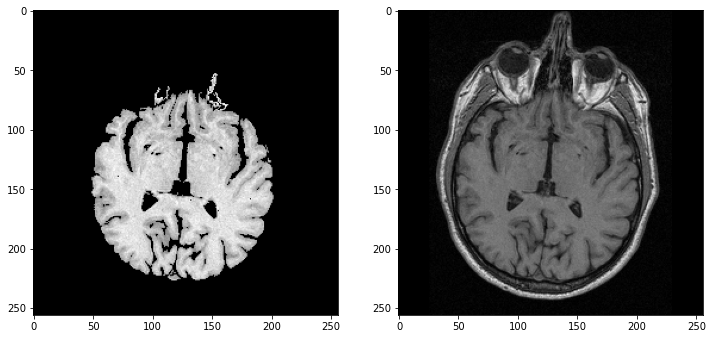

The number of pixels in the brain region is 16834


In [3]:
# Add your implementation and discussion
length=brain_im.shape[0] # Length of image
sample=brain_im[130:150,140:160] # Sample of image to mean onto
brain_copy=brain_im.copy()

thresh=np.mean(sample)*0.6
thresh2=np.mean(sample)*1.2

start=[200,70]
region=[start]
Exploring_map=np.zeros((length,length))
Exploring_map[start[0],start[1]]=2
process=True

while process :
    for pixel in region:
        X,Y = np.mgrid[pixel[0]-1:pixel[0]+2,pixel[1]-1:pixel[1]+2]#Find surrounding pixels
        Xsurr,Ysurr=np.vstack((X.ravel(), Y.ravel())) 
        Surr=np.vstack((Xsurr,Ysurr)).T #Making array with surrounding pixels coordinates
        for exp in Surr :
            if (Exploring_map[exp[0],exp[1]] == 0): # If never explored
                if brain_copy[exp[0],exp[1]]>thresh and brain_copy[exp[0],exp[1]]<thresh2 : #If in range for brain
                    Exploring_map[exp[0],exp[1]] = 2
                else:
                    Exploring_map[exp[0],exp[1]] = 1 # If never explored and not in threshold
            elif Exploring_map[exp[0],exp[1]] ==2:# If already inquired, try once more for pixels around
                Exploring_map[exp[0],exp[1]]=3
            elif Exploring_map[exp[0],exp[1]] ==3:# If already inquired, exclude from next pixels to explore
                Exploring_map[exp[0],exp[1]]=4    
                
    region=np.vstack((np.where((Exploring_map==2)|(Exploring_map==3)))).transpose()
    if region.shape[0]==0:
        process = False
    
mask=(Exploring_map<2)
brain_copy[mask]=0 #See the whole brain region

# Display Images of the brain
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_copy,cmap='gray')
ax[1].imshow(brain_im, cmap='gray')
plt.show()

print('The number of pixels in the brain region is',np.count_nonzero(brain_copy))

### 1.3 Contour detection (5pts)

### Process explanation

In our contour detection algorithm we choose to use the canny edge detector from scikit-image library.

#### Short explanation of the canny edge detector :
Wikipedia definition : The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986. 
First step in to remove the noise by applying a Gaussian filter to the image. We can set the sigma value in function's argument.
Second step, is near from what we saw in class. It is question to calculate the gradient of the image. But here the particularity is the gradient is calculated in direction perpendicular to the contour.
Then it is performed a non-Maximum suppression process.The principle is simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions and connect all dots along the contour.
Finally, edge pixels are kept or removed using hysteresis thresholding on the gradient magnitude : based on the double threshold results, the hysteresis consists of transforming weak pixels ( i.e belong to edges but not enough to be considered as strong pixels) into strong ones, if and only if at least one of the pixels around the one being processed is a strong one.

#### Extraction process.
As canny edge detector is high accuracy algorithm, we used morphology transformation to not have all contours inside the brain for example.(Tweak sigma value not led to satisfying outcomes)
We did a dilation and a closing in order to get by find_contours function the main image's edges (first plot)
Then, we noted that the brain contours was the longest regarding all contours detected, therefore we selected it.
To conclude our processing, we would like to create a mask for all pixels inside the brain contours. Thanks polygon function from scikit-image library, we set 1 within the contours and 0 outside. We also performed some morphology to expand (dilation) fill the boundaries holes (opening and closing) of our polygon shape. Thereupon, we just applied the mask with a numpy function.

#### Advantages/disadantages
Advantages : 
- The contour detection algorithm is useful to get a broad view of the elements of interest
- Canny edge detector can give us a lot of accurate contours of image
- With a mask method, afterward it is easier to compute the number of pixels

Limitations :
- In our way, we can't delete no desired pixels inside the contours
- Need to morphology tranformation and it is not always very accuracy
- As you can see, we choose to expand the brain selection area hence sometimes we could get undesired pixels (as the cavity between patient eyes)

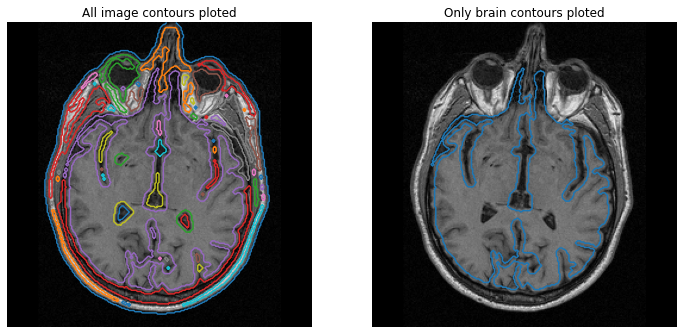

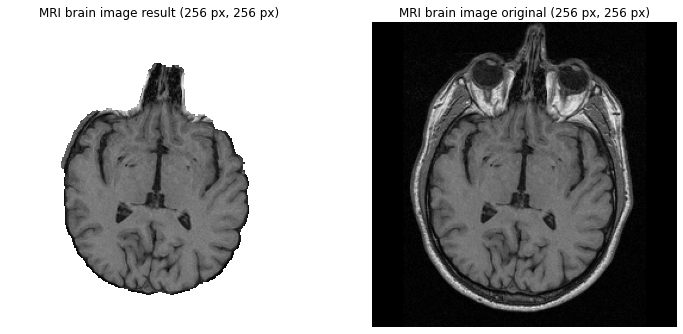

The number of pixels in the brain region is extracted by contour detection =  22003


In [4]:
from skimage import measure,feature
from skimage.morphology import disk, dilation, opening, closing
from skimage.draw import polygon
import numpy as np

#Canny edge detection to highlight image edges
canny_edges = feature.canny(brain_im, sigma=2)

#Morphology transformation to simply contours detection
base_shape = disk(1)
dilated_canny= dilation(canny_edges,base_shape)
closed_canny = closing(dilated_canny,base_shape)

#contours image
contours_canny=measure.find_contours(closed_canny,0.2) #get contours detection

brain_contours = max(contours_canny, key=len) #the brain contours is the longest

#Display images result comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(brain_im, cmap='gray')
for contour in contours_canny:
    ax[0].plot(contour[:, 1], contour[:, 0], linewidth=1.5)
ax[0].set_title('All image contours ploted')
ax[0].axis('off')
ax[1].imshow(brain_im, cmap='gray')
ax[1].plot(brain_contours[:, 1], brain_contours[:, 0], linewidth=1.5)
ax[1].set_title('Only brain contours ploted')
ax[1].axis('off')
plt.show()

#create a mask to extract brain pixels within contours
mask = np.zeros(brain_im.shape)
rr, cc = polygon(brain_contours[:, 0], brain_contours[:, 1], mask.shape)
mask[rr, cc] = 1

#Morphology processing to fill the hole and get as best as possible the brain
base_shape = disk(5)
dilated_mask = dilation(mask,base_shape)
opened_mask = opening(dilated_mask,base_shape)
closed_mask = closing(opened_mask,base_shape)

closed_mask = np.logical_not(closed_mask)#keep the mask's original values 

result_image_closed = np.ma.array(brain_im.copy(), mask=closed_mask)

#Display images result comparison
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].imshow(result_image_closed, cmap='gray')
ax[0].set_title('MRI brain image result ({} px, {} px)'.format(im_h, im_w))
ax[0].axis('off')
ax[1].imshow(brain_im, cmap='gray')
ax[1].set_title('MRI brain image original ({} px, {} px)'.format(im_h, im_w))
ax[1].axis('off')
plt.show()

print('The number of pixels in the brain region is extracted by contour detection = ',(256*256) - np.sum(closed_mask)) #mask=1 outside brain contours

### 1.4 Additional method: Region Splitting (5pts)

In [5]:

#First we create an object Region that encapuslats several features of every region
class Region: 
    def __init__(self, lower_left_x, lower_left_y, upper_right_x, upper_right_y):  
        

        #The coordinates of the corners of the region
        self.lower_left_x= lower_left_x
        self.lower_left_y = lower_left_y
        self.upper_right_x=upper_right_x
        self.upper_right_y=upper_right_y 
        
        
    def homog(self):#homogeneity condition
        
        mm=brain_im[self.lower_left_x:self.upper_right_x,
                  self.lower_left_y:self.upper_right_y]
        m=mm.mean()
        if m>thresh and m<thresh2: #check if it belongs to the brain
            #print('m1:',m)
            return 1
        elif m<10:  #check if its black
            #print('m2:',m)
            return 2
        else:
            return 3
    def mean(self):
        mm=brain_im[self.lower_left_x:self.upper_right_x,
                  self.lower_left_y:self.upper_right_y]
        return mm.mean()
        
    def size(self):# returns the length of the largest side of the region
        xl=self.lower_left_x;
        yl=self.lower_left_y;
        xr=self.upper_right_x;
        yr=self.upper_right_y;
        return max([xr-xl,yr-yl])
    
    def split(self): # determines weather to split the region horizontally or vertically
        xl=self.lower_left_x; yl=self.lower_left_y; xr=self.upper_right_x; yr=self.upper_right_y;
        if [xr-xl]>=[yr-yl]:
            return False
        else: 
            return True

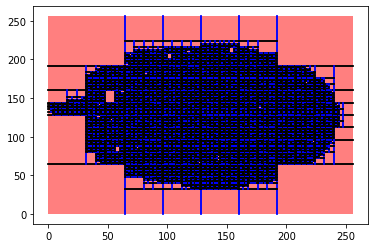

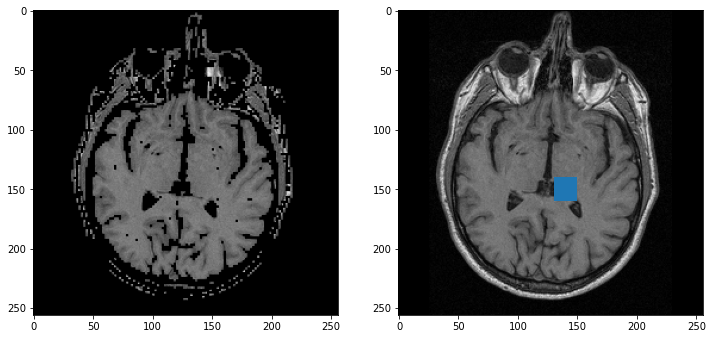

The area of the brain is given by:  21228.0  pixels


In [6]:
####Parameters #####
length=brain_im.shape[0]
brain_copy=brain_im.copy()
sample=brain_im[130:150,140:160]
thresh=np.mean(sample)*1.1
thresh2=np.mean(sample)*1.11

label_map=np.zeros(brain_im.shape)
list_sp=[] #creation of the list
list_sp.append(Region(0,0,brain_im.shape[0],brain_im.shape[1])) # addition of the image as first region
count=0

#### Visualisation ####
rect=Rectangle((0,0),brain_im.shape[0],brain_im.shape[1],facecolor='r',edgecolor='None', alpha=0.5)
fig, ax = plt.subplots()
ax.add_patch(rect)



#### Start of the algorithm ####
while len(list_sp)>0 and count<=100: #while the list of regions is not empty 
    for region in list_sp:      
        list_sp.remove(region) #we remove the analysed region from the list
        if region.homog()==1: # if region satisfies homogeity condition 
            #print("1")
            label_map[region.lower_left_x:region.upper_right_x,
                      region.lower_left_y:region.upper_right_y]=1 # 1 is in Brain
        elif region.homog()==2: # if region is black or research region is small it is considered as no brain
            #print("2")
            label_map[region.lower_left_x:region.upper_right_x,
                      region.lower_left_y:region.upper_right_y]=0 #0 is out of brain
        elif region.size()<4:    
            if region.mean()<= thresh:
                if thresh-region.mean()<region.mean()-10:
                    label_map[region.lower_left_x:region.upper_right_x,
                      region.lower_left_y:region.upper_right_y]=1 # 1 is in Brain
                else:
                    label_map[region.lower_left_x:region.upper_right_x,
                      region.lower_left_y:region.upper_right_y]=0 # 1 is not in Brain
            elif region.mean()>=1.1*thresh2:
                label_map[region.lower_left_x:region.upper_right_x,
                      region.lower_left_y:region.upper_right_y]=0 # 1 is notin Brain                
        else: # if the considered region its not defined, it gets split            
            #print("3")
            xl=region.lower_left_x;
            yl=region.lower_left_y;
            xr=region.upper_right_x;
            yr=region.upper_right_y;
            horizontal=region.split()
            if horizontal: #the split is either horizontal (50% of the time)
                #print("4")
                region1=Region(xl,yl,xr,round(yl+(yr-yl)/2))
                region2=Region(xl,round(yl+(yr-yl)/2),xr,yr)
                
                ax.plot([region2.lower_left_x ,region2.upper_right_x],
                        [region2.lower_left_y, region2.lower_left_y], color='black')
                ax.plot([region1.lower_left_x ,region1.upper_right_x],
                        [region1.upper_right_y, region1.upper_right_y], color='black')
                
            else: #the split can also be vertical 
                #print("5")     
                region1=Region(xl,yl,round(xl+(xr-xl)/2),yr) 
                region2=Region(round(xl+(xr-xl)/2),yl,xr,yr)
                
                ax.plot([region2.lower_left_x ,region2.lower_left_x],
                      [region2.lower_left_y, region2.upper_right_y],color='blue')
                ax.plot([region1.upper_right_x ,region1.upper_right_x],
                       [region1.lower_left_y, region1.upper_right_y],color='blue')
     
            list_sp.append(region1) 
            list_sp.append(region2)
    count+=1
plt.show()   



#### Visualization #####

brain_dedieu=np.multiply(brain_im,label_map,)
# Display Images of the brain
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
ax[0].imshow(brain_dedieu, cmap='gray')
ax[1].imshow(brain_im, cmap='gray')
rect1=Rectangle((130,140),20,20)
ax[1].add_patch(rect1)
plt.show()


#### Amount of pixels in brain #####
px_num=label_map.sum().sum()
print('The area of the brain is given by: ', px_num,' pixels')

## Conclusion for region splitting

We can notice that this method does not allow to isolate the brain but takes into account all reginos that have approximately the same intensity. Which explains the high amount of pixels that are classified in the brain. We can conclude that this method can be appropriate to isolate object which present high gradients of intensity, with respect to the back ground, but is less powerful for images with low graidents just like this brain image.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [7]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


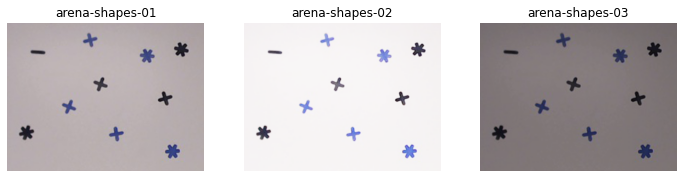

In [8]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

#### Process explanation
The library open Cv is here used to compute the colors and the number of shapes of each color.
Two main functions are here used :
- A normalization function in order to get coherent results for different intensities
- A function to get a number of shades of colors of an image, with its associated number of pixels

The K-means clustering method is used choosing a precise number of clusters, each cluster corresponding to one color. The pixels closest in value to those clusters are associated to one of the colors

A loop is then created to find the number of dominant colors in the image : starting from a total of 10 colors, the number decreases until the colors found are sufficiently different one from another.

In the aim of finding the number of shapes, the contours are found using the cv library. Once the number of shapes is found, each shape is associated with a previously found color by finding the closest from its own color.

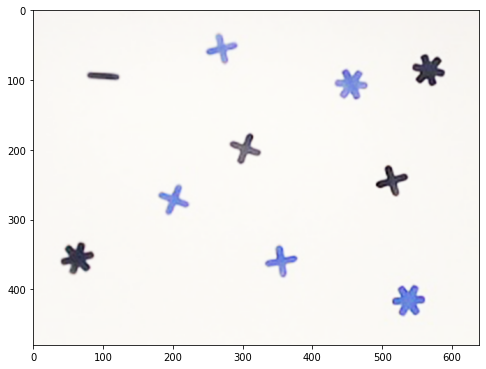

The number of dominant colors in this image is :  3


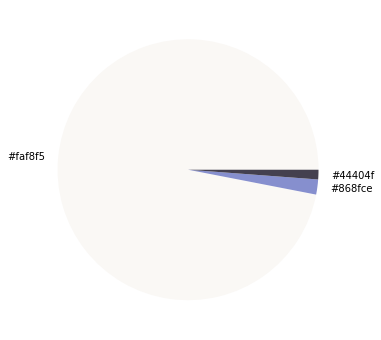

In [9]:
#Source :
#https://github.com/kb22/Color-Identification-using-Machine-Learning/blob/master/Color%20Identification%20using%20Machine%20Learning.ipynb

import cv2
from collections import Counter
from skimage import measure
from skimage.color import rgb2lab, deltaE_cie76,rgb2gray
from sklearn.cluster import KMeans
import itertools
from PIL import Image
import scipy as sc

def get_image(num):
    image = images[num]
    return image

def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    
    for i in range(3):
        minval = arr[...,i].min()
        maxval = arr[...,i].max()
        if minval != maxval:
            arr[...,i] -= minval
            arr[...,i] *= (255.0/(maxval-minval))
    return arr

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_colors(image, number_of_colors, show_chart):
    modified_image = image
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
   
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors,counts


image = get_image(1) #Choose which image to take

arr=np.array(image)
image = np.array(Image.fromarray(normalize(arr).astype('uint8'),'RGB'))  #Normalize it

fig, ax = plt.subplots(1, 1, figsize=(8, 8)) #Plot it
ax.imshow(image)
plt.show()

not_stable = True
num_colors=10 #Initial number of colors to be found in the image

while not_stable:
    rgb,counts=get_colors(image, num_colors, False)
    it=0

    for a, b in itertools.combinations(rgb, 2): #Compare every color with all the others
        it+=1
        if np.linalg.norm(a-b)<100: #If shades of color are too close
            num_colors-=1 
            break
        else: 
            if(it==sc.special.binom(num_colors,2)): #Check if last iteration
                rgb,counts=get_colors(image, num_colors, True)
                not_stable = False        
print('The number of dominant colors in this image is : ', num_colors)


In [10]:
# Find the contours to find the number of elements
gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 190, 255, 0)
contours, hierarchy= cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
number_of_objects_in_image= len(contours)

colpix=np.array(list(counts.copy().items()))
idx=np.argmax(colpix[:,1])
colpix = np.delete(colpix,idx,0)#Remove background from colors for the objects

#Find to which color the elements belong
color_table=np.zeros(number_of_objects_in_image)
for num in range(number_of_objects_in_image):
    center=(np.floor(np.mean(contours[num],axis=0)))
    weight_color=1000
    for num2 in range(num_colors):       
        new_weight=np.linalg.norm(image[int(center[0,1]),int(center[0,0])]-rgb[num2])
        if(new_weight<weight_color):
            weight_color=new_weight
            color_table[num]=num2

            
color_table = np.delete(color_table,idx)
#print('Color table:',color_table)
print ("The number of objects in this image: ", str(number_of_objects_in_image-1))
for num in colpix[:,0]:
    print('The number of shape for color',num,'is',list(color_table).count(num))
    
#To draw the contours :
'''
cv2.drawContours(image,contours,-1,(0,255,255),2)
cv2.namedWindow('Display',cv2.WINDOW_NORMAL)
cv2.imshow('Display',image)
cv2.waitKey()
'''

The number of objects in this image:  10
The number of shape for color 1 is 5
The number of shape for color 2 is 5


"\ncv2.drawContours(image,contours,-1,(0,255,255),2)\ncv2.namedWindow('Display',cv2.WINDOW_NORMAL)\ncv2.imshow('Display',image)\ncv2.waitKey()\n"

### 2.3 Total area (in pixels) of each color (5 pts)

In [11]:
for num in colpix[:,0]: 
    print('The number of pixels for the color',num,'is',colpix[num-1,1])

The number of pixels for the color 1 is 5717
The number of pixels for the color 2 is 3663
